In [1]:
##' ---
##' title: "Simulate and Update in libKriging: a mockup"
##' date: "`r Sys.Date()`"
##' author: "libKriging team"
##' output: html_document
##' ---

# Set default behavior of subsetting without dropping dimensions:
old = `[`
`[` = function(...) { old(..., drop=FALSE) }

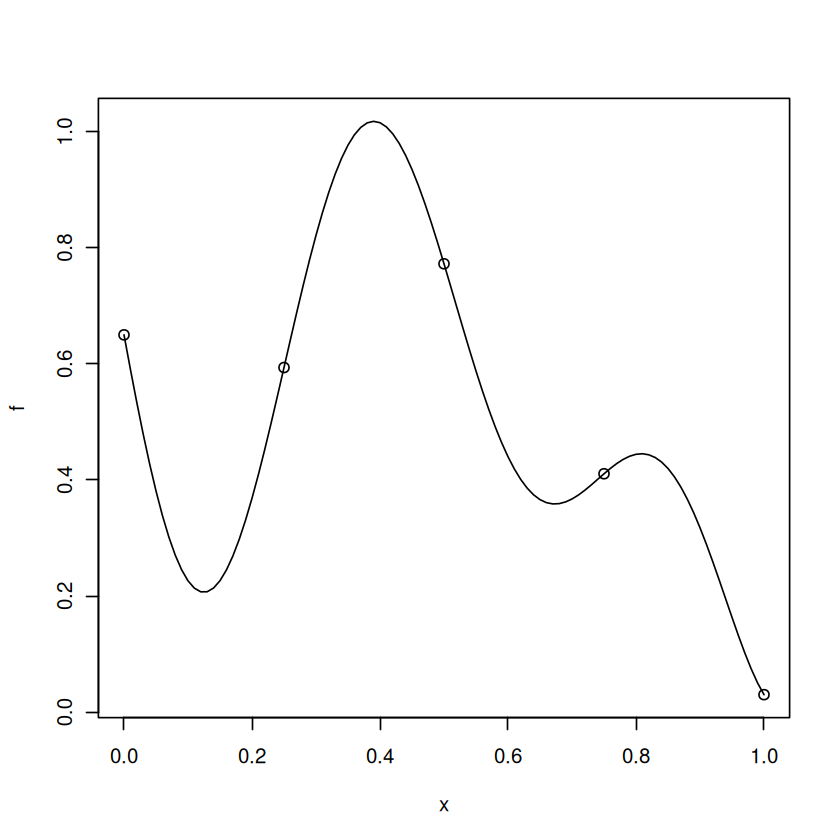

In [2]:
f = function(x) {
    1 - 1 / 2 * (sin(12 * x) / (1 + x) + 2 * cos(7 * x) * x^5 + 0.7)
}
plot(f)
n = 5
X_o = seq(from = 0, to = 1, length.out = n)
y_o = f(X_o)
points(X_o, y_o)

In [3]:
#options(repos=list(CRAN='https://packagemanager.posit.co/cran/__linux__/jammy/latest/')) # use prebuilt binaries if possible -> faster
#if (!'rlibkriging' %in% installed.packages())
#  remotes::install_url('https://github.com/libKriging/rlibkriging/releases/download/0.9-a/rlibkriging_0.8-3_R_x86_64-pc-linux-gnu.tar.gz', dependencies = TRUE, build=FALSE)
#
#library(rlibkriging)
library(rlibkriging, lib.loc="/home/richet/Sync/Open/libKriging/alien/libKriging/bindings/R/Rlibs")
lk = Kriging(y = matrix(y_o, ncol = 1),
              X = matrix(X_o, ncol = 1),
              kernel = "gauss",
              regmodel = "linear",
              optim = "none",
              parameters = list(theta = matrix(0.1), sigma2=0.1))

# print aux var of model for checking
print(list(X=lk$X(),Y=lk$y(), theta = lk$theta(),
           F = lk$F(),
           T = lk$T(),
           M = lk$M(),
           beta = lk$beta(),
           z = lk$z(),
           sigma2 = lk$sigma2()))


Attachement du package : ‘rlibkriging’


Les objets suivants sont masqués depuis ‘package:base’:

    load, save




$X
     [,1]
[1,] 0.00
[2,] 0.25
[3,] 0.50
[4,] 0.75
[5,] 1.00

$Y
           [,1]
[1,] 0.65000000
[2,] 0.59372607
[3,] 0.77240277
[4,] 0.41073158
[5,] 0.03024098

$theta
     [,1]
[1,]  0.1

$F
     [,1] [,2]
[1,]    1 0.00
[2,]    1 0.25
[3,]    1 0.50
[4,]    1 0.75
[5,]    1 1.00

$T
             [,1]         [,2]         [,3]       [,4]      [,5]
[1,] 1.000000e+00 0.000000e+00 0.000000e+00 0.00000000 0.0000000
[2,] 4.393693e-02 9.990343e-01 0.000000e+00 0.00000000 0.0000000
[3,] 3.726653e-06 4.397924e-02 9.990324e-01 0.00000000 0.0000000
[4,] 6.101937e-13 3.730255e-06 4.397932e-02 0.99903244 0.0000000
[5,] 1.928750e-22 6.107835e-13 3.730262e-06 0.04397932 0.9990324

$M
          [,1]      [,2]
[1,] 1.0000000 0.0000000
[2,] 0.9569872 0.2502417
[3,] 0.9588364 0.4894681
[4,] 0.9587551 0.7291781
[5,] 0.9587587 0.9688669

$beta
           [,1]
[1,]  0.7746904
[2,] -0.5717783

$z
            [,1]
[1,] -0.12469036
[2,] -0.03257265
[3,]  0.28531062
[4,]  0.05237800
[5,] -0.17514513

$sigm

In [4]:
KM0 = function(X, y, theta, sigma2, 
               Cov = function(dx,theta){exp(-0.5*(dx)^2/theta^2)}) {
  X = as.matrix(X)
  n = nrow(X)
  d = 1 #d = ncol(X)

  dX = array(NA,n*n)
  for (ij in 1:(n*n)) {
    i = (ij-1) %/% n +1
    j = ij - (i-1)*n # ij => i,j
    dX[ij] = dX[(i-1)*n + j] = X[i]-X[j]
  }

  F = cbind(1,X) # trend: y~1+x
  p = ncol(F)

  R = matrix(NA,n,n)
  for (i in 1:n) {
    R[i,i] = 1.0
    for (j in 1:(i-1)) {
      R[i,j] = R[j,i] = Cov(dX[(i-1)*n+j], theta)
    }
  }

  L = t(chol(R)) # T = t(chol(R))

  Fystar = solve(L, cbind(F, y)) # M = solve(T,F)
  Fstar = Fystar[ , 1:p]
  ystar = Fystar[ , p+1] # Yt = solve(T,y)

  QRFystar = qr(Fystar) # QR = qr(M)
  RFystar = qr.R(QRFystar) # Q = qr.Q(QR)
  QFystar = qr.Q(QRFystar) # G = qr.R(QR)

  Rstar = RFystar[1:p, 1:p]
  betahat = solve(Rstar, RFystar[1:p, p+1]) # beta = solve(G,t(Q) %*% Yt)
  Estar = QFystar[ , p+1] * as.vector(RFystar[p+1, p+1]) # z = Yt - M %*% beta
  SSEstar = RFystar[p+1, p+1]^2 # sigma2 = sum(z*z)/n

  betacov =solve(t(Rstar) %*% Rstar)

	return(list(X=X,y=y,
              theta=theta,sigma2=sigma2,
              Fystar=Fystar,Fstar=Fstar,ystar=ystar,Rstar=Rstar,
              L=L,F=F,R=R,
              betahat=betahat, #beta.cov = betacov,
              Estar=Estar,SSEstar=SSEstar,
              Cov=Cov))
}

rK = KM0(X_o,y_o, 0.1, 0.1)
print(rK)

# check if the results are the same:
# | KM0         | libKriging            |
# | ---         | ---                   |
# | F           | F                     |
# | Rstar       | (Q)                   |
# | Fstar       | M                     |
# | ystar       | (Yt=) z + M %*% beta) |
# | L           | T                     |
# | Fystar      | M                     |
# | betahat     | beta                  |
# | Estar       | z                     |
# | SSEstar /n  | sigma2                |


$X
     [,1]
[1,] 0.00
[2,] 0.25
[3,] 0.50
[4,] 0.75
[5,] 1.00

$y
[1] 0.65000000 0.59372607 0.77240277 0.41073158 0.03024098

$theta
[1] 0.1

$sigma2
[1] 0.1

$Fystar
                                  y
[1,] 1.0000000 0.0000000 0.65000000
[2,] 0.9569872 0.2502417 0.56571336
[3,] 0.9588364 0.4894681 0.74824467
[4,] 0.9587551 0.7291781 0.37818809
[5,] 0.9587587 0.9688669 0.01361891

$Fstar
                        
[1,] 1.0000000 0.0000000
[2,] 0.9569872 0.2502417
[3,] 0.9588364 0.4894681
[4,] 0.9587551 0.7291781
[5,] 0.9587587 0.9688669

$ystar
              y
[1,] 0.65000000
[2,] 0.56571336
[3,] 0.74824467
[4,] 0.37818809
[5,] 0.01361891

$Rstar
                         
[1,] -2.161856 -1.0809280
[2,]  0.000000  0.7773019

$L
             [,1]         [,2]         [,3]       [,4]      [,5]
[1,] 1.000000e+00 0.000000e+00 0.000000e+00 0.00000000 0.0000000
[2,] 4.393693e-02 9.990343e-01 0.000000e+00 0.00000000 0.0000000
[3,] 3.726653e-06 4.397924e-02 9.990324e-01 0.00000000 0.0000000
[4,]

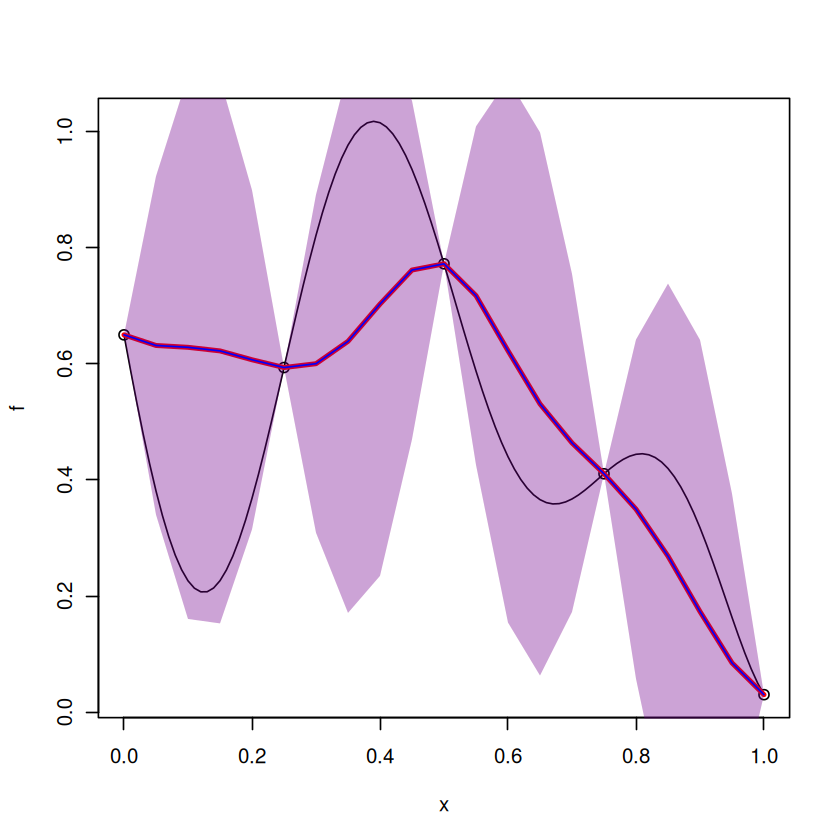

In [5]:
predict_KM0 = function(K, X_n) {
  n_o = nrow(K$X)
  X_n = as.matrix(X_n)
  n_n = nrow(X_n)
  # d = 1

  F_n = cbind(1,X_n) # trend: y~1+x

  R_on = matrix(NA, n_o, n_n)
  for (i in 1:n_o) {
    for (j in 1:n_n) {
      R_on[i,j] = K$Cov(K$X[i]-X_n[j], K$theta)
    }
  }

  Rstar_on = solve(K$L, R_on) # Tinv_R_on = solve(K$T,R_on)

  yhat_n = F_n %*% K$betahat + t(Rstar_on) %*% K$Estar
 # Ym_n = F_n %*% K$beta + t(Tinv_R_on) %*% K$z

  #TM = t(chol(t(K$M) %*% K$M))
  Fhat_n = t(Rstar_on) %*% K$Fstar
  E_n = F_n - Fhat_n
  Ecirc_n = E_n %*% solve(K$Rstar) # S2_n = solve(TM,t(F_n - t(Tinv_R_on) %*% K$M))
  #Fstarcirc = K$Fstar %*% solve(K$Rstar) ## XXX unused

  #s2_n_2 = colSums(S2_n * S2_n)
  #s2_n_1 = colSums(Tinv_R_on * Tinv_R_on)
  #Ysd2_n = K$sigma2 * (1 - s2_n_1 + s2_n_2)
  ysd2hat_n  = (1 - (colSums(Rstar_on * Rstar_on)) + (rowSums(Ecirc_n * Ecirc_n)))
  ysd2hat_n[ysd2hat_n < 0] = 0 #Ysd2_n[Ysd2_n < 0] = 0

  R_nn = matrix(NA_real_, nrow = n_n, ncol = n_n)
  for (i in 1:n_n) {
      R_nn[i, i] = 1
      for (j in 1:(i-1)) {
          R_nn[i, j] = R_nn[j, i] = K$Cov(X_n[i] - X_n[j], K$theta)
      }
  }

  Sigma_n = R_nn - t(Rstar_on) %*% Rstar_on +  Ecirc_n %*% t(Ecirc_n)

  Linv = solve(K$L, diag(n_o))
  ## Note that the inverse covariance is useful only for the
  ## Kriging Weight matrix, not for the covariance
  Rinv_oo = t(Linv) %*% Linv
  Fcirc = K$F %*% solve(K$Rstar)
  mat = t(R_on) + Ecirc_n %*% t(Fcirc)
  W_n = mat %*% Rinv_oo

  return(list(mean=yhat_n, stdev=sqrt(K$sigma2 * ysd2hat_n), cov=K$sigma2 * Sigma_n , W=W_n ))
}

x_n = seq(0,1,,21)

lp = lk$predict(x_n) # libK predict
rp = predict_KM0(rK,x_n)

plot(f)
points(X_o,y_o)
lines(x_n,lp$mean,col='red',lwd=3)
polygon(c(x_n,rev(x_n)),c(lp$mean+2*lp$stdev,rev(lp$mean-2*lp$stdev)),col=rgb(1,0,0,0.2),border=NA)
lines(x_n,rp$mean,col='blue')
polygon(c(x_n,rev(x_n)),c(rp$mean+2*rp$stdev,rev(rp$mean-2*rp$stdev)),col=rgb(0,0,1,0.2),border=NA)

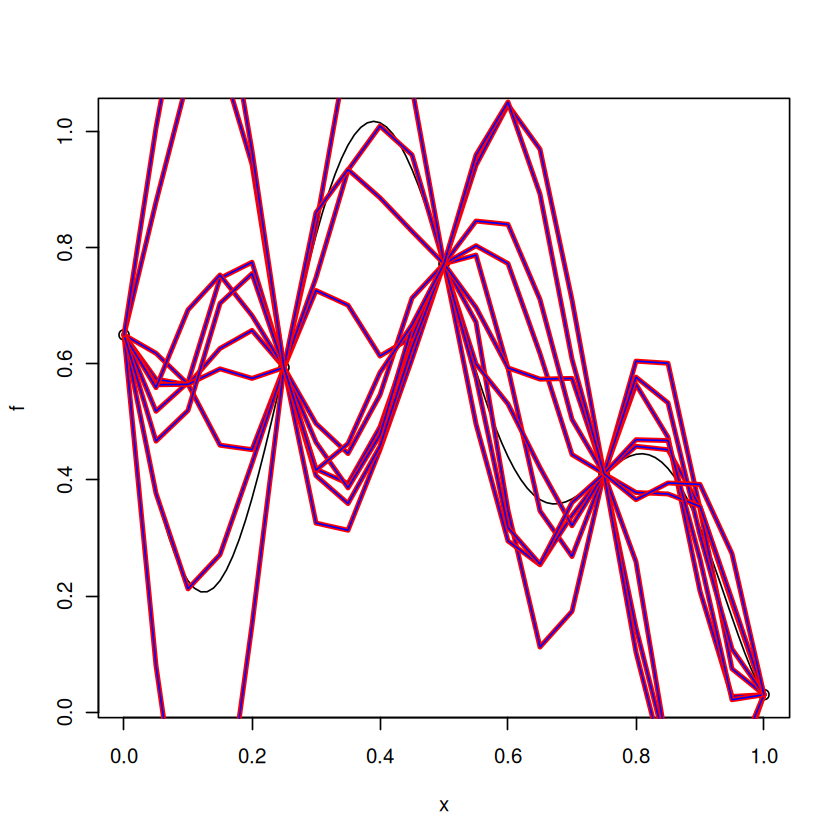

In [6]:
simulate_KM0 = function(K, nsim, seed, X_n, will_update=FALSE) {
  n_o = nrow(K$X)
  X_n = as.matrix(X_n)
  n_n = nrow(X_n)
  # d = 1

  F_n = cbind(1,X_n) # trend: y~1+x
  p = ncol(F_n)
	#trend_n = F_n %*% K$betahat

  R_nn =  matrix(NA, n_n, n_n)
  for (i in 1:n_n) {
      R_nn[i, i] = 1
      for (j in 1:(i-1)) {
          R_nn[i, j] =  R_nn[j, i] =  K$Cov(X_n[i] - X_n[j], K$theta)
      }
  }

  R_on =  matrix(NA, n_o, n_n)
  for (i in 1:n_o) {
    for (j in 1:n_n) {
      R_on[i,j] = K$Cov(K$X[i]-X_n[j], K$theta)
    }
  }

  Rstar_on = solve(K$L, R_on) # Tinv_R_on = solve(K$T,R_on)
  yhat_n = F_n %*% K$betahat + t(Rstar_on) %*% K$Estar # trend_n = trend_n  + t(Rstar_on) %*% K$z

  Fhat_n = t(Rstar_on) %*% K$Fstar
  E_n = F_n - Fhat_n
  Ecirc_n = E_n %*% solve(K$Rstar)

	# Conditional correlation matrix
  ## S_c = R_nn
	## S_c[upper.tri(R_nn,diag=FALSE)] = 0
  ## for (i in 1:m) {
  ##   for (j in 1:i) {
  ##     S_c[i,j] = S_c[i,j] - sum(Tinv_R_on[,i] * Tinv_R_on[,j])
  ##     S_c[j,i] = S_c[i,j]
  ##   }
  ## }
  # S_c = R_nn - t(Tinv_R_on) %*% Tinv_R_on ## matrix version

  SigmaNoTrend_nKo = R_nn - t(Rstar_on) %*% Rstar_on
  Sigma_nKo = SigmaNoTrend_nKo  + Ecirc_n %*% t(Ecirc_n)

  LSigma_nKo = t(chol(Sigma_nKo + diag(1e-11,n_n,n_n)))

	y_n = matrix(yhat_n, n_n, nsim)
  rlibkriging:::random_reset_seed(seed)
  y_n = y_n  + LSigma_nKo %*% rlibkriging:::random_randn_mat(n_n,nsim) * sqrt(K$sigma2)
  #rlibkriging:::random_reset_seed(seed+1)
  #y_n = y_n  +  Ecirc_n %*% rlibkriging:::random_randn_mat(p,nsim) * sqrt(as.vector(K$SSEstar) / n_o)

  if (will_update) {
  
  ######## to be built within simulate(... will_update=TRUE) #####################

    ## Update Cholesky root of the covariance. This is part of the
    ## tasks that would be involved in 'update.KM0(theKM0, yu =
    ## yn, and X_u = X_n)' but we only compute the matrices. Use
    ## section 3.2.3 with 'u' replaced by 'n'.

    L_oCn = Rstar_on #solve(K$L, R_on)
    L_nCn = t(chol(SigmaNoTrend_nKo + diag(1e-11, nrow = n_n, ncol = n_n)))
    L_on = cbind(rbind(K$L, t(L_oCn)),
                  rbind(matrix(0.0, n_o, n_n), L_nCn))

    Linv_on = solve(L_on)
    Rinv_on = t(Linv_on) %*% Linv_on

    ## Compute the transformed matrix of trend on 'X_on' and its QR
    ## decomposition
    F_on = rbind(K$F, F_n)
    Fstar_on = solve(L_on, F_on)
    QRFstar_on = qr(Fstar_on)
    RFstar_on = qr.R(QRFstar_on)
    Fcirc_on = F_on %*% solve(RFstar_on)      # dim (n_on, p)
################################################################################
  
  .Last.simulate <<- list(seed=seed, X_n = X_n, nsim = nsim,
                          y_n=y_n,
                          R_nn = R_nn, R_on = R_on, L_on=L_on,L_oCn=L_oCn,
                          F_n = F_n,F_on=F_on,
                          Fstar_on=Fstar_on,RFstar_on=RFstar_on,Fcirc_on=Fcirc_on,Rinv_on=Rinv_on)
  }

  return(y_n)
}

ls = lk$simulate(10, 123, x_n) # libK simulate
rs = simulate_KM0(rK, 10, 123, x_n)

plot(f)
points(X_o,y_o)
for (i in 1:10) {
    lines(x_n,ls[,i],col='red',lwd=3)
    lines(x_n,rs[,i],col='blue')
}
# red and blue lines must be close

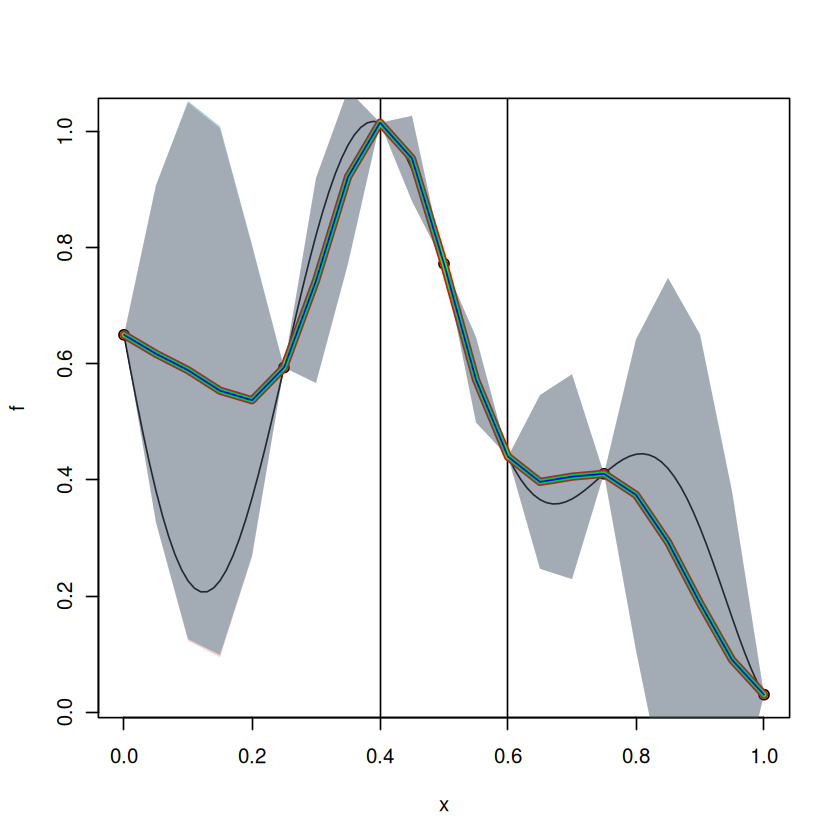

In [7]:
update_KM0 = function(K, X_u, y_u) {
  X_u = as.matrix(X_u)
  n_u = nrow(X_u)
  # d = 1

  F_u = cbind(1,X_u) # trend: y~1+x
  p = ncol(F_u)

  X_o = as.matrix(K$X)
  n_o = nrow(X_o)
  y_o = K$y
  F_o = K$F

  R_uu = matrix(NA, nrow = n_u, ncol = n_u)
  for (i in 1:n_u) {
      R_uu[i, i] = 1.0
      for (j in 1:(i-1)) {
          R_uu[i, j] = R_uu[j, i] = K$Cov(X_u[i] - X_u[j], K$theta)
      }
  }

  R_ou = matrix(NA, n_o, n_u)
  for (i in 1:n_o) {
    for (j in 1:n_u) {
      R_ou[i,j] = K$Cov(X_o[i]-X_u[j], K$theta)
    }
  }

    ## Update the Cholesky root of the correlation
    L_oCu = solve(K$L, R_ou)
    L_uCu = t(chol(R_uu - t(L_oCu) %*% L_oCu +
                    diag(1e-11, n_u, n_u)))
    L_ou = cbind(rbind(K$L, t(L_oCu)),
                  rbind( matrix(0,n_o, n_u), L_uCu))

    #R = matrix(NA,n_o+n_u,n_o+n_u)
    #R[1:n_o,1:n_o] = K$R
    #R[(n_o+1):(n_o+n_u),(n_o+1):(n_o+n_u)] = R_uu
    #R[1:n_o,(n_o+1):(n_o+n_u)] = R_ou
    #R[(n_o+1):(n_o+n_u),1:n_o] = t(R_ou)
    #L_ou = t(chol(R))

    F_ou = rbind(F_o, F_u)
    y_ou = c(y_o, y_u)
    Fystar_ou = solve(L_ou, cbind(F_ou, y_ou))
    Fstar_ou = Fystar_ou[ , 1:p]
    ystar_ou = Fystar_ou[ , p+1]

    QRFystar_ou = qr(Fystar_ou) # QR = qr(M)
  RFystar_ou = qr.R(QRFystar_ou) # Q = qr.Q(QR)
  QFystar_ou = qr.Q(QRFystar_ou) # G = qr.R(QR)

    Rstar_ou = RFystar_ou[1:p, 1:p]
    betahat_ou = solve(Rstar_ou, RFystar_ou[1:p,  p+1])
    Estar_ou = QFystar_ou[ , p+1] * as.vector( RFystar_ou[p+1, p+1] )
    SSEstar_ou = RFystar_ou[p+1, p+1]^2

    covBeta_ou = solve(t(Rstar_ou) %*% Rstar_ou)


	return(list(X=rbind(X_o, X_u),y=y_ou, 
              theta=K$theta, sigma2=K$sigma2,
              Fystar=Fystar_ou,Fstar=Fstar_ou,ystar=ystar_ou,Rstar=Rstar_ou,
              L=L_ou,F=F_ou,
              betahat=betahat_ou,Estar=Estar_ou,SSEstar=SSEstar_ou,
              Cov=K$Cov))

}

X_u = c(.4,.6)
y_u = f(X_u)

# new Kriging model from scratch
rK2 = KM0(c(X_o,X_u),c(y_o,y_u), 0.1, 0.1)
# update previous Kriging model
rKu = update_KM0(rK, X_u, y_u )

#for (n in names(rK)) {
#  print(paste0(n," :", all.equal(rKu[[n]],rK2[[n]])))
#}
x_un = sort(unique(round(c(x_n,X_u),10))) # unique (at 1e-10) and sorted
rp2 = predict_KM0(rK2,x_un)
rpu = predict_KM0(rKu,x_un)

lk2 = copy(lk)
lk2$update(y_u, X_u, refit=FALSE)
lpu = lk2$predict(x_un)

plot(f)
points(X_o,y_o)
abline(v=X_u)
lines(x_un,rp2$mean,col='red', lwd=5)
polygon(c(x_un,rev(x_un)),c(lpu$mean+2*lpu$stdev,rev(lpu$mean-2*lpu$stdev)),col=rgb(1,0,0,0.2),border=NA)
lines(x_un,rp2$mean,col='green', lwd=3)
polygon(c(x_un,rev(x_un)),c(rp2$mean+2*rp2$stdev,rev(rp2$mean-2*rp2$stdev)),col=rgb(0,1,0,0.2),border=NA)
lines(x_un,rpu$mean,col='blue')
polygon(c(x_un,rev(x_un)),c(rpu$mean+2*rpu$stdev,rev(rpu$mean-2*rpu$stdev)),col=rgb(0,0,1,0.2),border=NA)


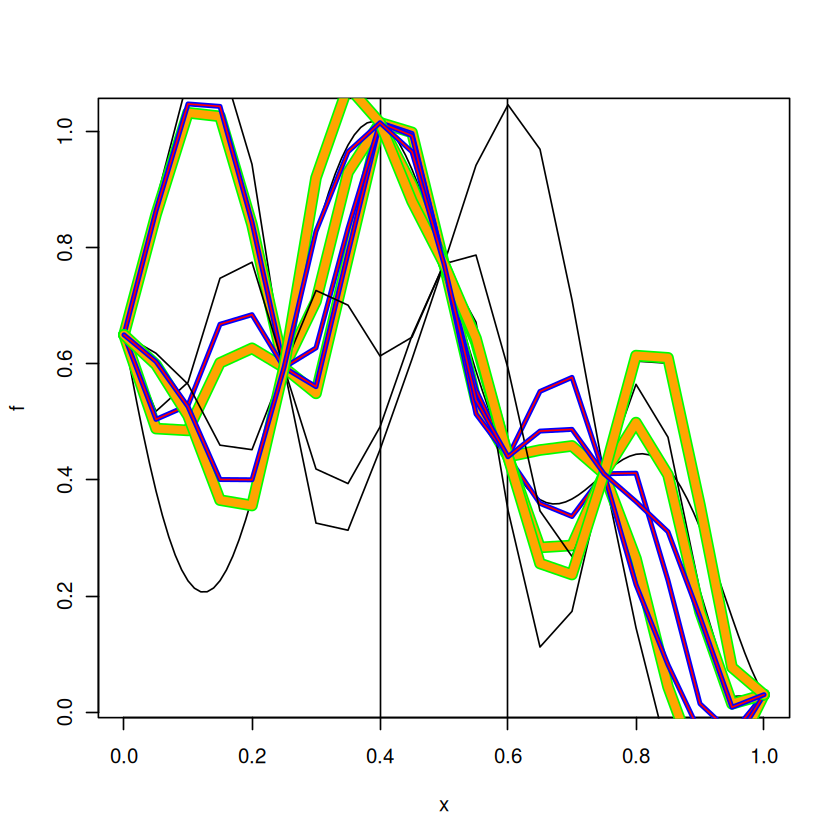

In [8]:
update_simulate_KM0 = function(K, S=.Last.simulate, X_u, y_u) {
    if (is.null(X_u)) X_u=S$X_u
    if (is.null(X_u)) stop("X_u must be provided or in .Last.simulate")

    X_u = as.matrix(X_u)
    n_u = nrow(X_u)
    F_u = cbind(1, X_u)
    p = ncol(F_u)

    X_o = as.matrix(K$X)
    n_o = nrow(X_o)
    y_o = K$y

    X_n = S$X_n
    n_n = nrow(X_n)
    y_n = S$y_n

    n_on = n_o + n_n
    X_on = rbind(X_o, X_n)
    F_on = rbind(K$F, S$F_n)

    if (is.null(S$R_uu)) {
        R_uu =  matrix(NA_real_, nrow = n_u, ncol = n_u)
        for (i in 1:n_u) {
            R_uu[i, i] = 1.0
            for (j in 1:(i-1)) {
                R_uu[i, j] =  R_uu[j, i] =  K$Cov(X_u[i] - X_u[j], K$theta)
            }
        }
    } else {
        R_uu = S$R_uu
    }

    if (is.null(S$R_uo)) {
        R_uo = matrix(NA_real_, n_u, n_o)
        for (i in 1:n_u) {
            for (j in 1:n_o) {
                R_uo[i, j] = K$Cov(X_u[i] - X_o[j], K$theta)
            }
        }
    } else {
        R_uo = S$R_uo
    }

    if (is.null(S$R_un)) {
        R_un =  matrix(NA_real_, n_u, n_n)
        for (i in 1:n_u) {
            for (j in 1:n_n) {
                R_un[i, j] = K$Cov(X_u[i] - X_n[j], K$theta)
            }
        }
    } else {
        R_un = S$R_un
    }

    R_nn = S$R_nn
    #matrix(NA_real_, n_n, n_n)
    #for (i in 1:n_n) {
    #    for (j in 1:n_n) {
    #        R_nn[i, j] = K$Cov(X_n[i] - X_n[j], K$theta)
    #    }
    #}

    ## ======================================================================
    ## FOXY step #1 Extend the simulation to the design 'X_u' IF
    ## NECESSARY. Remind that the simulation number j is
    ## conditional on the given 'y_o' and on 'y_n = Y_sim[ , j]'
    ##
    ## CAUTION. To avoid unnecessary re-computations we here use
    ## auxiliary variables that where computed in the creation of
    ## the KM0 step AND later in the simulation. The first ones are
    ## in 'theKM0$Extra' and the second ones are in 'Ex'
    ##
    ## In indices 'C' means comma and 'K' means pipe '|'
    ##
    ## ======================================================================

######## to be built within simulate(... will_update=TRUE) #####################
#
#    ## Update Cholesky root of the covariance. This is part of the
#    ## tasks that would be involved in 'update.KM0(theKM0, yu =
#    ## yn, and X_u = X_n)' but we only compute the matrices. Use
#    ## section 3.2.3 with 'u' replaced by 'n'.
#
#    L_oCn = solve(K$L, S$R_on)
#    L_nCn = t(chol(R_nn - t(L_oCn) %*% L_oCn + diag(1e-11, nrow = n_n, ncol = n_n)))
#    L_on = cbind(rbind(K$L, t(L_oCn)),
#                  rbind(matrix(0.0, n_o, n_n), L_nCn))
#
#    Linv_on = solve(L_on)
#    Rinv_on = t(Linv_on) %*% Linv_on
#
#    ## Compute the transformed matrix of trend on 'X_on' and its QR
#    ## decomposition
#    Fstar_on = solve(L_on, F_on)
#    QRFstar_on = qr(Fstar_on)
#    RFstar_on = qr.R(QRFstar_on)
#    Fcirc_on = F_on %*% solve(RFstar_on)      # dim (n_on, p)
################################################################################


if (is.null(S$Y_simu_n)) {
    ## Compute the matrices of the Universal Kriging as usual
    ## with here n_on = n_o + n_n obs.
    R_onCu = t(cbind(R_uo, R_un))            # dim (n_on, n_u)
    Rstar_onCu = solve(S$L_on, R_onCu)         # dim (n_on, n_u)
    Ecirc_uKon = (F_u - t(Rstar_onCu) %*% S$Fstar_on) %*% solve(S$RFstar_on)

    ## Compute the conditional covariance matrix
    Sigma_uKon = R_uu - t(Rstar_onCu) %*% Rstar_onCu + Ecirc_uKon %*% t(Ecirc_uKon) 

    LSigma_uKon = chol(Sigma_uKon + diag(1e-11, nrow = n_u, ncol = n_u))

    ## Compute the matrix 'W_uCon' of Kriging Weights with dim
    ## (n_u, n_on)
    W_uCon = (t(R_onCu) + Ecirc_uKon %*% t(S$Fcirc_on)) %*% S$Rinv_on

    ## Compute the mean matrix 'M_u' with dim '(n_u, nsim)'. The
    ## object 'm_u' is a vector with length 'n_u'
    m_u = W_uCon[ , 1:n_o] %*% K$y
    M_u = m_u[ , rep(1, S$nsim)] + W_uCon[ , n_o + (1:n_n)] %*% S$y_n
    
    Y_sim_u = M_u
    rlibkriging:::random_reset_seed(S$seed)
    Y_sim_u = Y_sim_u +  LSigma_uKon %*% rlibkriging:::random_randn_mat(n_u,S$nsim) * sqrt(K$sigma2)
    #rlibkriging:::random_reset_seed(S$seed+1)
    #Y_sim_u = Y_sim_u + Ecirc_uKon %*% rlibkriging:::random_randn_mat(p,S$nsim)
} else Y_sim_u = S$Y_sim_u 

    ## ======================================================================
    ## FOXY step #2   Update the simulated paths on 'X_n'
    ## ======================================================================

if (is.null(S$W.tilde_nKu)) {
    ## copy for convenience, not necessary
    Fstar_o = K$Fstar

    Rstar_ou = solve(K$L, t(R_uo))
    ## prediction of the trend and the corresponding error matrices
    Fhat_uKo = t(Rstar_ou) %*% Fstar_o
    Ecirc_uKo = (F_u - Fhat_uKo) %*% solve(K$Rstar)
    
    Rstar_on = S$L_oCn #solve(K$L, S$R_on) 
    Fhat_nKo = t(Rstar_on) %*% Fstar_o #!!! tbd in simulate(...,will_update=TRUE)
    Ecirc_nKo = (S$F_n - Fhat_nKo) %*% solve(K$Rstar)#!!! tbd in simulate(...,will_update=TRUE)

    ## blocks in the conditional Kernel matrix
    R.tilde_uCu = R_uu - t(Rstar_ou) %*% Rstar_ou + Ecirc_uKo %*% t(Ecirc_uKo)
    R.tilde_nCu = t(R_un) - t(Rstar_on) %*% Rstar_ou + Ecirc_nKo %*% t(Ecirc_uKo)

    W.tilde_nKu = t(solve(R.tilde_uCu, t(R.tilde_nCu)))
} else W.tilde_nKu=S$W.tilde_nKu

    Y_sim_n = S$y_n +
        W.tilde_nKu %*% (as.matrix(y_u)[ , rep(1, S$nsim)] - Y_sim_u)

    #if (will_update && is.null(X_u)) {
    .Last.simulate <<- c(.Last.simulate,
        list(X_u=X_u, Y_sim_u=Y_sim_u,
            W.tilde_nKu=W.tilde_nKu, 
            R_uo=R_uo, R_un=R_un, R_uu=R_uu))
    #}

    return (Y_sim_n)
}

X_u = c(.4,.6)
y_u = f(X_u)

rs = simulate_KM0(rK, 10, 123, x_n, will_update=TRUE) # also creates a global variable .Last.simulate, which is used in coming update_simulate_KM0
#y_u = rs[i_u,1] # force matching 1st sim

rsu = update_simulate_KM0(rK, .Last.simulate, X_u, y_u)

rKu = update_KM0(rK, X_u, y_u)
rus = simulate_KM0(rKu, 10, 123, x_un)

ls = lk$simulate(10, 123, x_un, will_update=TRUE)
lsu = lk$update_simulate(y_u, X_u)

lu = copy(lk)
lu$update(y_u, X_u)
lus = lu$simulate(10, 123, x_un, will_update=FALSE)

plot(f)
points(X_o,y_o)
abline(v=X_u)
for (i in 1:3) {
    lines(x_un,rs[,i])
    lines(x_un,rsu[,i],col='green',lwd=7)
    lines(x_un,lsu[,i],col='orange',lwd=5)
    lines(x_un,rus[,i],col='blue',lwd=3)
    lines(x_un,lus[,i],col='red')
}
